# 🧠 Neural Networks from Scratch

**Goal:** By the end of this notebook, you'll understand exactly what happens
when someone says "the model is training." No magic, no hand-waving.

We'll build a neural network using only NumPy (basic math), train it to solve
a problem that a single neuron *cannot* solve, and then see how PyTorch
automates what we did manually.

---

## What We'll Cover
1. **The XOR Problem** — Why we need hidden layers
2. **Building a Neural Network** — Forward pass from scratch
3. **The Training Loop** — Loss, backprop, weight updates
4. **Watching It Learn** — Visualizing training
5. **Breaking It** — What happens with bad hyperparameters
6. **PyTorch Version** — Same thing, less code

Let's go.

# Part 1: The XOR Problem

## Why XOR?

XOR (exclusive or) is a simple logical operation:
- If inputs are **different** → output 1
- If inputs are **the same** → output 0

| Input A | Input B | Output |
|---------|---------|--------|
| 0 | 0 | 0 |
| 0 | 1 | 1 |
| 1 | 0 | 1 |
| 1 | 1 | 0 |

### The Historical Importance

In 1969, Minsky and Papert proved that a single-layer perceptron (one neuron)
**cannot learn XOR**. This caused the first "AI Winter" — people thought neural
networks were fundamentally limited.

The solution? **Hidden layers.** A network with at least one hidden layer CAN
learn XOR. This notebook proves it.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Our training data: XOR

X =np.array([
    [0,0],
    [0,1],
    [1,0],
    [1,1]
])

y =np.array([
    [0],
    [1],
    [1],
    [0]
])

In [3]:
print("XOR Dataset:")
print("-" *30)

for i in range(len(X)):
    print(f"Input: {X[i]} -> Output: {y[i][0]}")

XOR Dataset:
------------------------------
Input: [0 0] -> Output: 0
Input: [0 1] -> Output: 1
Input: [1 0] -> Output: 1
Input: [1 1] -> Output: 0


## Visualize the problem

Let's plot the XOR data. You'll see why a straight line can't separate the classes.


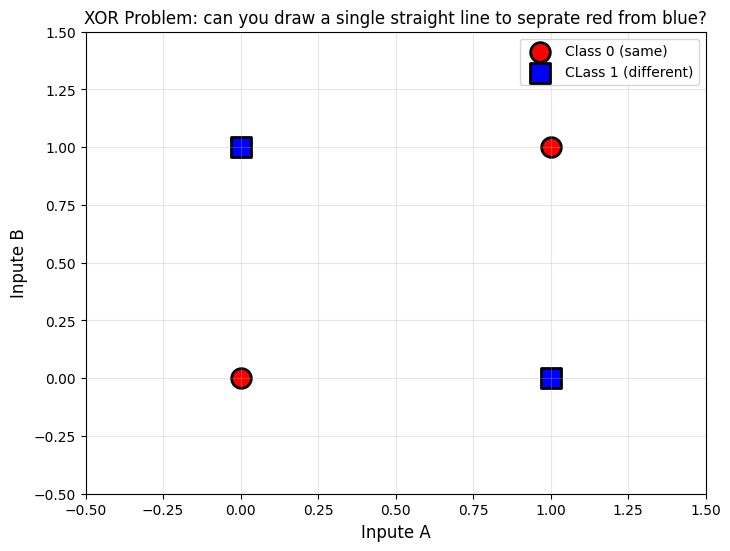

In [4]:
plt.figure(figsize=(8, 6))

#plot the points

for i in range(len(X)):
    color = 'red' if y[i][0] ==0 else 'blue'
    marker = 'o' if y[i][0] == 0 else 's'
    plt.scatter(X[i][0], X[i][1], c=color, s=200, marker=marker,
                edgecolors='black', linewidths=2)
    
plt.xlabel("Inpute A", fontsize=12)
plt.ylabel("Inpute B", fontsize=12)
plt.title('XOR Problem: can you draw a single straight line to seprate red from blue?', fontsize=12)

plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 1.5)
plt.grid(True, alpha=0.3)
plt.legend(['Class 0 (same)', 'CLass 1 (different)'], loc='upper right')
plt.show()

    

---
# Part 2: Building the Neural Network

## Our Architecture

```
Input Layer (2 neurons) → Hidden Layer (4 neurons) → Output Layer (1 neuron)
```

- **Input:** 2 values (the two XOR inputs)
- **Hidden:** 4 neurons with sigmoid activation
- **Output:** 1 neuron with sigmoid activation (gives us 0-1 probability)

### Why Sigmoid?

For this educational example, we use sigmoid everywhere because:
1. Output is naturally between 0 and 1 (matches our target)
2. The math is clean and easy to follow
3. It's historically important

In practice, you'd use ReLU for hidden layers. But sigmoid helps us see
what's happening.

In [5]:
# Network architecture

INPUT_SIZE =2  # two inpute
HIDDEN_SIZE =4
OUTPUT_SIZE = 1  # one output (0 or 1)

In [6]:
# Weights from input to hidden layer (2 inputes -> 4 hidden neurons)
weights_input_hidden =np.random.randn(INPUT_SIZE, HIDDEN_SIZE) * 0.5

bias_hidden =np.zeros((1, HIDDEN_SIZE))

In [7]:
# Weights from hidden to output layer (4 hidden neurons -> 1 output)

weights_hidden_output = np.random.randn(HIDDEN_SIZE, OUTPUT_SIZE) * 0.5
bias_output =np.zeros((1, OUTPUT_SIZE))

In [8]:
print("Network intialized with random weights:")
print(f"INput -> HIdden weights shape: {weights_input_hidden.shape}")
print(f"Hidden -> Ouput weights shape: {weights_hidden_output.shape}")
print(f"\n Total parameters: {weights_input_hidden.size + bias_hidden.size + weights_hidden_output.size + bias_hidden.size}")

Network intialized with random weights:
INput -> HIdden weights shape: (2, 4)
Hidden -> Ouput weights shape: (4, 1)

 Total parameters: 20


# The Activation Function : Sigmoind

Sigmoid squashes any number into the range (0,1)
* Large positive number -> close to 1
* Large negative number -> close to 0
* Zero -> exactly 0.5

In [9]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    s =sigmoid(x)
    return s * (1 - s)


/tmp/ipykernel_2533/839750078.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


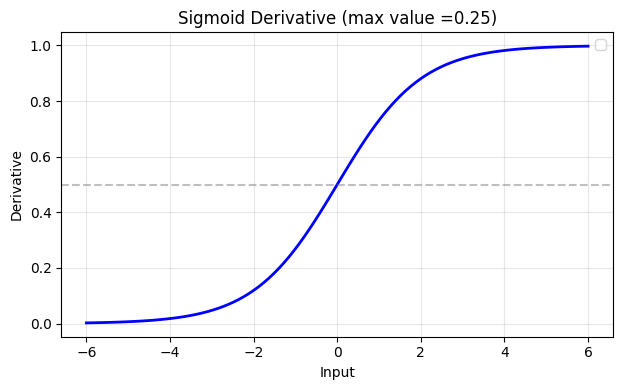

In [10]:
# Visualize sigmoid

x_range =np.linspace(-6, 6, 100)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(x_range, sigmoid(x_range), 'b-', linewidth=2)
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
plt.xlabel('Input')
plt.ylabel('Derivative')

plt.title('Sigmoid Derivative (max value =0.25)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
print("\nNotice: The maximum derivative is only 0.25!")
print("Thise is the vanishing gradient problem.")
print(" 10 layers: 0.25^10 =", 0.25**10)


Notice: The maximum derivative is only 0.25!
Thise is the vanishing gradient problem.
 10 layers: 0.25^10 = 9.5367431640625e-07


## Forward Pass

The forward pass is how data flows through the network:

1. **Input → Hidden:** Multiply inputs by weights, add bias, apply activation
2. **Hidden → Output:** Multiply hidden by weights, add bias, apply activation

Let's trace through exactly what happens.

In [12]:
def forward(X):

    """
    Forward pass through the network.
    Return all intermediate values (we need them for backprop).
    """

    # Step 1: Input to Hidden
    # z_hidden = X @ W + b (linear combination)
    z_hidden =np.dot(X, weights_input_hidden) + bias_hidden

    # a_hidden =sigmoid(z_hidden) (activation)
    a_hidden =sigmoid(z_hidden)

    # Step 2: Hidden to Output
    # z_output = a_hidden @ W + b
    z_output = np.dot(a_hidden, weights_hidden_output) + bias_output

    # a_output =sigmoid(z_output)
    a_output = sigmoid(z_output)

    # Return everything (we need z values for backprop)
    return z_hidden, a_hidden, z_output, a_output

In [13]:
# Test forward pass with untrained network

z_h, a_h, z_o, predictions =forward(X)

In [14]:
print("Forward pass with UNTRAINED network:")
print("-" * 50)

for i in range(len(X)):
    print(f"Input: {X[i]} -> Prediction: {predictions[i][0]:.4f} (Target: {y[i][0]})")

print("\n Predictions are garbage - the network has'nt learned anything yet.")


Forward pass with UNTRAINED network:
--------------------------------------------------
Input: [0 0] -> Prediction: 0.5738 (Target: 0)
Input: [0 1] -> Prediction: 0.5995 (Target: 1)
Input: [1 0] -> Prediction: 0.5851 (Target: 1)
Input: [1 1] -> Prediction: 0.6073 (Target: 0)

 Predictions are garbage - the network has'nt learned anything yet.


# Loss Function: Mean Square Error

Loss measures how wrong our predictions are. Lower=better

MSE =mean((prediction -target)2)

We square the error so:
* All errors are positive
* Big errors are penalized more than small errors


In [15]:
def compute_loss(y_true, y_pred):
    """Mean Squared Error"""
    return np.mean((y_true -y_pred) ** 2)

In [16]:
# Claculate initial loss

initial_loss =compute_loss(y, predictions)
print(f"Initial Loss (untrained): {initial_loss:.4f}")
print("\nThis number should decrease as we train.")

Initial Loss (untrained): 0.2576

This number should decrease as we train.


# Part 3: Backpropagation

This is where the magic happens. Backprop answers: **"Which weights caused the error, and how much?"**

## The Chain of Blame

1. Calculate error at output
2. Figure out how much each output weight contributed
3. Propagate error back to hidden layer
4. Figure out how much each hidden weight contributed
5. Adjust all weights proportionally

The math uses the chain rule from calculus, but the intuition is simple:
**blame flows backward.**

In [17]:
def backward(X, y, z_hidden, a_hidden, z_output, a_output, learning_rate):
    """
    Backpropagation: compute gradients and update weights.
    """
    global weights_input_hidden, bias_hidden, weights_hidden_output, bias_output

    m = X.shape[0]  # Number of training examples

    # ============ OUTPUT LAYER ============
    # Error at output: difference between prediction and target
    output_error = a_output - y  # Shape: (4, 1)

    # Gradient of loss w.r.t. z_output (before activation)
    # This combines the error with the sigmoid derivative
    output_delta = output_error * sigmoid_derivative(z_output)  # Shape: (4, 1)

    # Gradient of loss w.r.t. weights_hidden_output
    # How much did each weight contribute to the error?
    grad_weights_hidden_output = np.dot(a_hidden.T, output_delta) / m
    grad_bias_output = np.mean(output_delta, axis=0, keepdims=True)

    # ============ HIDDEN LAYER ============
    # Propagate error back to hidden layer
    hidden_error = np.dot(output_delta, weights_hidden_output.T)

    # Gradient of loss w.r.t. z_hidden
    hidden_delta = hidden_error * sigmoid_derivative(z_hidden)

    # Gradient of loss w.r.t. weights_input_hidden
    grad_weights_input_hidden = np.dot(X.T, hidden_delta) / m
    grad_bias_hidden = np.mean(hidden_delta, axis=0, keepdims=True)

    # ============ UPDATE WEIGHTS ============
    # Move weights in the opposite direction of the gradient
    # (gradient points uphill, we want to go downhill)
    weights_hidden_output -= learning_rate * grad_weights_hidden_output
    bias_output -= learning_rate * grad_bias_output
    weights_input_hidden -= learning_rate * grad_weights_input_hidden
    bias_hidden -= learning_rate * grad_bias_hidden

print("Backpropagation function defined.")
print("This is the 'learning' part — adjusting weights to reduce error.")

Backpropagation function defined.
This is the 'learning' part — adjusting weights to reduce error.


---
# Part 4: The Training Loop

Now we put it all together:

```
for each iteration:
    1. Forward pass → get predictions
    2. Calculate loss → how wrong are we?
    3. Backward pass → compute gradients, update weights
```

Let's train for 10,000 iterations and watch the loss decrease.

In [18]:
# Reset weights (in case you run this cell multiple times)

np.random.seed(42)
weights_input_hidden =np.random.randn(INPUT_SIZE,HIDDEN_SIZE) * 0.5
bias_hidden = np.zeros((1, HIDDEN_SIZE))
weights_hidden_output =np.random.randn(HIDDEN_SIZE, OUTPUT_SIZE) * 0.5
bias_output = np.zeros((1, OUTPUT_SIZE))

In [19]:
# Hyperparameters
learning_rate = 2.0
iterations = 10000

In [20]:
# Track loss over time
loss_history = []

In [21]:
print("Training started ...")
print("-" * 50)

for i in range(iterations):
    # Forward pass
    z_h, a_h, z_o, predictions =forward(X)

    # Calculate loss
    loss = compute_loss(y, predictions)
    loss_history.append(loss)

    # Backward pass (updates weights internally)
    backward(X, y, z_h, a_h, z_o, predictions, learning_rate)

    # Pring progress
    if i % 2000 == 0:
        print(f"Iterations {i:5d} | Loss: {loss:.6f}")

Training started ...
--------------------------------------------------
Iterations     0 | Loss: 0.255675
Iterations  2000 | Loss: 0.005210
Iterations  4000 | Loss: 0.001005
Iterations  6000 | Loss: 0.000529
Iterations  8000 | Loss: 0.000355


Let's See the Results!

In [22]:
# Final predictions
_, _, _, final_predictions = forward(X)

print("Final Results After Training:")
print("-" * 50)
print(f"{'Input':<12} {'Target':<10} {'Prediction':<12} {'Rounded':<10}")
print("-" * 50)

for i in range(len(X)):
    pred = final_predictions[i][0]
    rounded = round(pred)
    status = "✅" if rounded == y[i][0] else "❌"
    print(f"{str(X[i]):<12} {y[i][0]:<10} {pred:<12.4f} {rounded:<10} {status}")

print("-" * 50)
print(f"\n🎉 The network learned XOR from random weights!")

Final Results After Training:
--------------------------------------------------
Input        Target     Prediction   Rounded   
--------------------------------------------------
[0 0]        0          0.0187       0          ✅
[0 1]        1          0.9845       1          ✅
[1 0]        1          0.9844       1          ✅
[1 1]        0          0.0151       0          ✅
--------------------------------------------------

🎉 The network learned XOR from random weights!


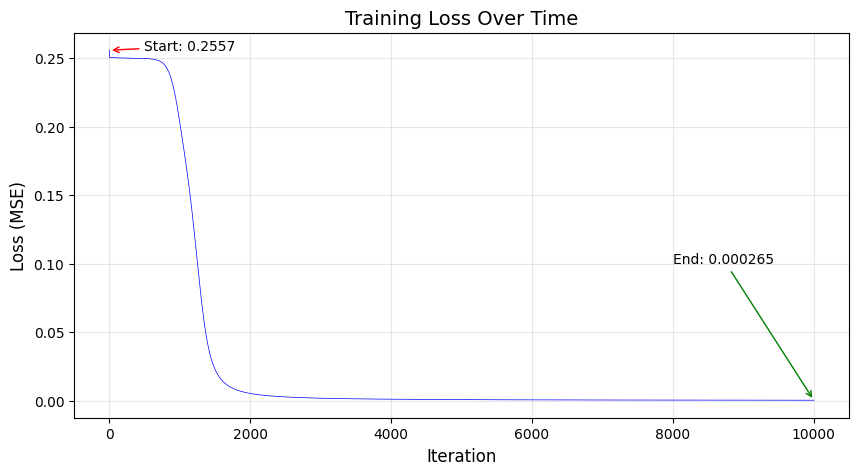

The loss started high (random guessing) and decreased (learning).


In [23]:
# Plot the loss curve
plt.figure(figsize=(10, 5))
plt.plot(loss_history, 'b-', linewidth=0.5)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training Loss Over Time', fontsize=14)
plt.grid(True, alpha=0.3)

# Add annotations
plt.annotate(f'Start: {loss_history[0]:.4f}',
             xy=(0, loss_history[0]), fontsize=10,
             xytext=(500, loss_history[0]),
             arrowprops=dict(arrowstyle='->', color='red'))
plt.annotate(f'End: {loss_history[-1]:.6f}',
             xy=(len(loss_history)-1, loss_history[-1]), fontsize=10,
             xytext=(len(loss_history)-2000, 0.1),
             arrowprops=dict(arrowstyle='->', color='green'))

plt.show()

print("The loss started high (random guessing) and decreased (learning).")

---
# Part 5: Breaking It (Experiments)

Understanding what breaks a network teaches you more than seeing it work.
Try these experiments:

## Experiment 1: Learning Rate Too High

In [24]:
# Reset and train with learning rate = 100 (way too high)

np.random.seed(42)
weights_input_hidden =np.random.randn(INPUT_SIZE, HIDDEN_SIZE) * 0.5
bias_hidden =np.zeros((1, HIDDEN_SIZE))
weights_hidden_output =np.random.randn(HIDDEN_SIZE, OUTPUT_SIZE) * 0.5
bias_output =np.zeros((1, OUTPUT_SIZE))

lr_high =100.0
loss_high_lr =[]

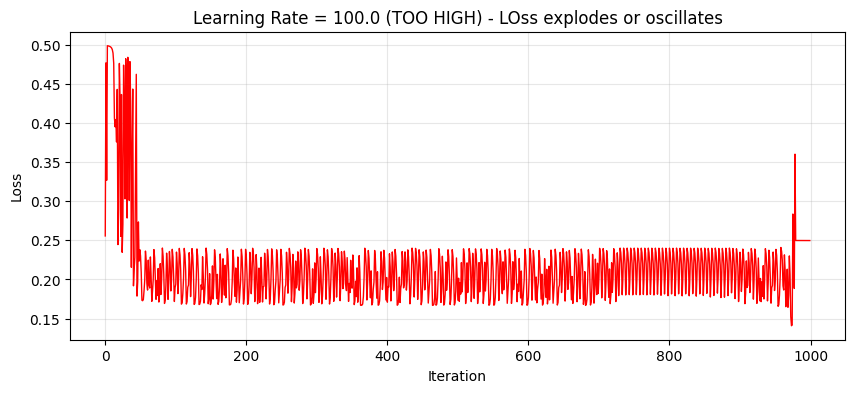

In [25]:
for i in range(1000):
    z_h, a_h, z_o, pred =forward(X)
    loss_high_lr.append(compute_loss(y, pred))
    backward(X, y, z_h, a_h, z_o, pred, lr_high)

plt.figure(figsize=(10, 4))
plt.plot(loss_high_lr, 'r-', linewidth=1)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title(f'Learning Rate = {lr_high} (TOO HIGH) - LOss explodes or oscillates')
plt.grid(True, alpha=0.3)
plt.show()

## Experiment 2: Learning Rate Too Low

In [26]:
# Reset and train with learning rate =0.001 (too low)
np.random.seed(42)
weights_input_hidden =np.random.randn(INPUT_SIZE, HIDDEN_SIZE) * 0.5
bias_hidden =np.zeros((1, HIDDEN_SIZE))
weights_hidden_output =np.random.randn(HIDDEN_SIZE, OUTPUT_SIZE) * 0.5
bias_output =np.zeros((1, OUTPUT_SIZE))

lr_low =0.001
loss_low_lr =[]

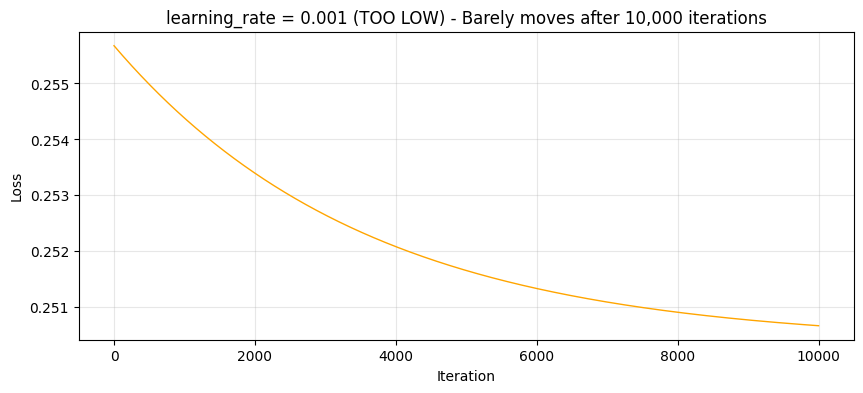

Predictions with low learning rate:
 [0 0] -> 0.4977 (target: 0)
 [0 1] -> 0.4852 (target: 1)
 [1 0] -> 0.4828 (target: 1)
 [1 1] -> 0.4716 (target: 0)

 with leaning rate too low, learning is painfully slow.


In [27]:
for i in range(10000):
    z_h, a_h, z_o, pred =forward(X)
    loss_low_lr.append(compute_loss(y, pred))
    backward(X, y, z_h, a_h, z_o, pred, lr_low)

plt.figure(figsize=(10, 4))
plt.plot(loss_low_lr, 'orange', linewidth=1)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title(f"learning_rate = {lr_low} (TOO LOW) - Barely moves after 10,000 iterations")
plt.grid(True, alpha=0.3)
plt.show()

final_pred_low =forward(X)[3]
print("Predictions with low learning rate:")
for i in range(len(X)):
    print(f" {X[i]} -> {final_pred_low[i][0]:.4f} (target: {y[i][0]})")
print("\n with leaning rate too low, learning is painfully slow.")

## Experiment 3: Not Enough Hidden Neurons

In [29]:
# Try with only 2 hidden neurons
np.random.seed(42)
w_ih_small =np.random.randn(2,2) * 0.5, # only 2 hidden neurons
b_h_small =np.zeros((1, 2))
w_ho_small =np.random.randn(2, 1) * 0.5
b_o_small =np.zeros((1, 1))

In [30]:
def forward_small(X):
    z_h =np.dot(X, w_ih_small) + b_h_small
    a_h =sigmoid(z_h)
    z_o =np.dot(a_h, w_ho_small) + b_o_small
    a_o =sigmoid(z_o)
    return z_h, a_h, z_o, a_o


In [32]:
def backward_small (X, y, z_h, a_h, z_o, a_o, lr):
    global w_ih_small, b_h_small, w_ho_small, b_o_small
    m =X.shape[0]

    output_delta = (a_o - y) * sigmoid_derivative(z_o)
    w_ho_small -= lr* np.dot(a_h.T, output_delta) / m
    b_o_small -= lr * np.mean(output_delta, axis=0, keepdims=True)

    hidden_delta =np.dot(output_delta, w_ho_small.T) * sigmoid_derivative(z_h)
    w_ih_small -= lr * np.dot(X.T, hidden_delta) / m
    b_h_small -= lr * np.mean(hidden_delta, axis=0, keepdims=True)

In [ ]:
loss_small = []

for i in range(10000):
    z_h, a_h, z_o, pred =forward_small(X)
    loss_small.append(compute_loss(y, pred))
    backward_small(X, y, z_h, a_h, z_o, pred, 2.0)

plt.figure(figsize=(10, 4))
plt.plot(loss_small, 'purple', linewidth=1)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Only 2 Hidden Neurons - Network struggle to learn XOR')
plt.grid(True, alpha=0.3)
plt.show()

final_small =forward_small(X)[3]

print("Predictions with only 2 hidden neurons:")
for i in range(len(X)):
    print(f" {X[i]} -> {final_small[i][0]:.4f} (target: {y[i][0]})")
print("\n with fewer neurons, the network may not have enough capacity.")

---
# Part 6: The PyTorch Version

Now let's see the same thing in PyTorch. Notice:
- `loss.backward()` does all the backprop math automatically
- `optimizer.step()` updates the weights automatically

**The concepts are identical. The code is cleaner.**

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim

# Convert data to PyTorch tensors
X_tensor = torch.FloatTensor(X)
y_tensor = torch.FloatTensor(y)

# Define the network
class XORNet(nn.Module):
    def __init__(self):
        super(XORNet, self).__init__()
        self.hidden = nn.Linear(2, 4)   # 2 inputs → 4 hidden
        self.output = nn.Linear(4, 1)   # 4 hidden → 1 output
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.sigmoid(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x

# Create network
torch.manual_seed(42)
model = XORNet()

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=2.0)

# Training loop
pytorch_loss_history = []

print("Training PyTorch model...")
print("-" * 50)

for i in range(10000):
    # Forward pass
    predictions = model(X_tensor)
    loss = criterion(predictions, y_tensor)
    pytorch_loss_history.append(loss.item())

    # Backward pass (automatic!)
    optimizer.zero_grad()  # Clear previous gradients
    loss.backward()        # Compute gradients (THIS IS BACKPROP!)
    optimizer.step()       # Update weights

    if i % 2000 == 0:
        print(f"Iteration {i:5d} | Loss: {loss.item():.6f}")

print("-" * 50)
print(f"Iteration {10000:5d} | Loss: {pytorch_loss_history[-1]:.6f}")

Training PyTorch model...
--------------------------------------------------
Iteration     0 | Loss: 0.286560
Iteration  2000 | Loss: 0.000779
Iteration  4000 | Loss: 0.000298
Iteration  6000 | Loss: 0.000179
Iteration  8000 | Loss: 0.000127
--------------------------------------------------
Iteration 10000 | Loss: 0.000098


In [36]:
# Compare results 
print("\n PyTorch Final Predictions:")
print("-" * 50)

with torch.no_grad():
    final_preds =model(X_tensor)
    for i in range(len(X)):
        pred =final_preds[i].item()
        print(f"Input: {X[i]} -> Predictions: {pred:.4f} (Target: {y[i][0]})")


 PyTorch Final Predictions:
--------------------------------------------------
Input: [0 0] -> Predictions: 0.0091 (Target: 0)
Input: [0 1] -> Predictions: 0.9890 (Target: 1)
Input: [1 0] -> Predictions: 0.9913 (Target: 1)
Input: [1 1] -> Predictions: 0.0105 (Target: 0)


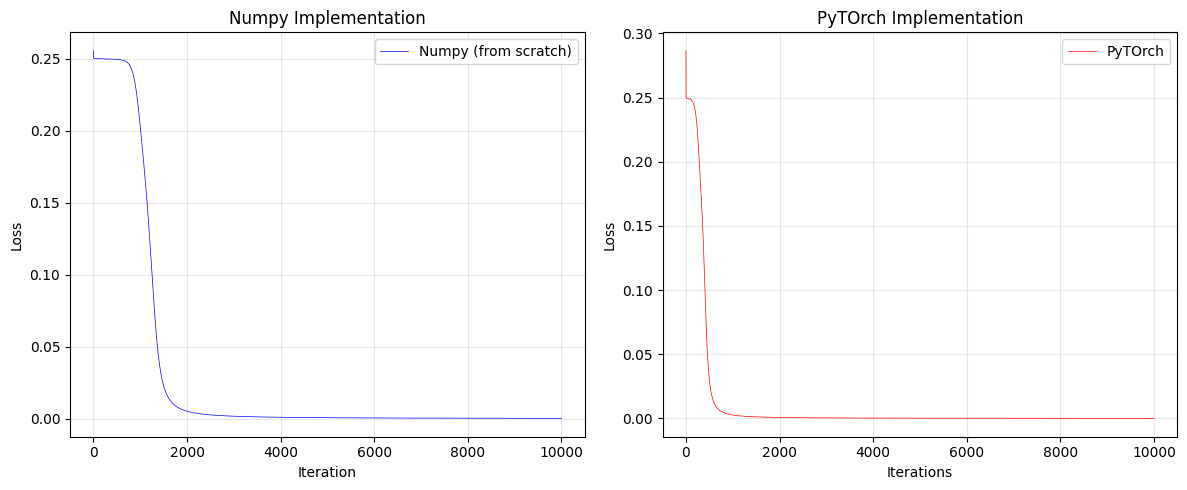


✅ Both implementations achieve the same result!
   PyTorch just automates the gradient calculations.


In [38]:
# Compare loss curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_history, 'b-', linewidth=0.5, label='Numpy (from scratch)')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Numpy Implementation')
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(pytorch_loss_history, 'r-', linewidth=0.5, label='PyTOrch')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('PyTOrch Implementation')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()


print("\n✅ Both implementations achieve the same result!")
print("   PyTorch just automates the gradient calculations.")